<a id="top"></a>

# Analyze PsyToolkit data

Behavioural data obtained from the PsyToolbox experiment.

- [Questionnaire](#quest)
- [Combine experiment data](#experiment)
- [Detection task](#detection_task)
    - [Statistical analysis](#detection_task_stats)
    - [Subgroup analysis](#detection_task_subgroup)
- [Rating task](#rating_task)
    - [Statistical analysis](#rating_task_stats)


In [1]:
from glob import glob
from scipy import stats
import re, pickle, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.miscmodels.ordinal_model

statsmodels.__version__

'0.13.0'

In [10]:
from pathlib import Path
home_dir = str(Path.home())
print('home_dir:', home_dir)

base_dir = os.path.join(home_dir, 'git/MRI-GAN-QA/')
data_dir = base_dir + 'experiment/data/'
image_dir = base_dir + 'experiment/Psytoolkit/'
fig_dir = base_dir + 'figures/'
results_dir = base_dir + 'results/'

print('datadir:', datadir)

home_dir: /Users/matthiastreder
datadir: /Users/matthiastreder/git/MRI-GAN-QA/experiment/data/


In [11]:
# exclude data from the authors
exclude_authors = [
    '2eb9e6be-e025-46c9-a8a7-fe0034d32dfe',
    '3341a4ce-466b-4c1a-8af7-d6d1b0db930c'
#     's.2eb9e6be-e025-46c9-a8a7-fe0034d32dfe.txt',
#     's.3341a4ce-466b-4c1a-8af7-d6d1b0db930c.txt'
]

In [12]:
# find completed files and remove authors' files
files = np.array(glob(data_dir + 'Fake_MRIs*.txt'))
files = [f for f in files if not ((exclude_authors[0] in f) or (exclude_authors[1] in f))]

# extract corresponding participant codes
participants_completed = [re.findall(r'Fake_MRIs\.\d{4}-\d{2}-\d{2}-\d{4}\.data\.([\w-]+)', file)[0] \
                for file in files]
print(len(participants_completed), 'participants complete')

26 participants complete


In [14]:
def clean_RT_data(df, RT_col, low_RT, high_RT, n_timeouts = None):
    '''Cleans RT data by removing too short RTs and removing participants with
    too many timeouts'''
    # time outs
    if n_timeouts is not None:
        timeout = df.groupby('participant')['timeout'].sum()
        timeout = timeout[timeout > n_timeouts]
        if timeout.shape[0] > 0:
            print(f'{timeout.shape[0]} participants have >{n_timeouts} timeouts, removing them')
            for ix in timeout.index:
                df = df[df['participant'] != ix] 
            
    # check lower RT bound
    df_low = df[df[RT_col] <= low_RT]
    if df_low.shape[0] > 0:
        print(f'Removing {df_low.shape[0]} trials with RT <= {low_RT}')
        df = df[df[RT_col] > low_RT]
    
    # check high RT bound
    df_high = df[df[RT_col] >= high_RT]
    if df_high.shape[0] > 0:
        print(f'Removing {df_high.shape[0]} trials with RT >= {high_RT}')
        df = df[df[RT_col] < high_RT]

    return df

In [15]:
def trim_mean_upper(x, prop=0.1):
    '''Calculates trimmed mean but trims only upper tail'''
    return x[x <= x.quantile(1-prop)].mean()

In [16]:
def wilcoxon_ranksum(target_col, group_col, subgroup_col = None):
    '''Wilcoxon ranksum tests (for different subgroups)
    target_col    - column with target values (eg RT, correct)
    group_col     - binary column that differentiates two groups (eg experience)
    subgroup_col  - column that defines subgroups for separate Wilcoxon tests'''
    if subgroup_col is None:
        g = group_col.unique()
        print(f'Test {target_col.name} for {group_col.name}={g}')
        result = stats.ranksums(target_col[group_col==g[0]], \
                                      target_col[group_col==g[1]])
#         print(result)
        print(f'p={result.pvalue:2.6f}')
    else: 
        # run multiple tests for different subgroups
        levels = subgroup_col.unique()
        g = group_col.unique()
        print(f'Test {target_col.name} for {group_col.name}={g}')
        for level in levels:
            result = stats.ranksums(target_col[(group_col==g[0])&(subgroup_col==level)], \
                                          target_col[(group_col==g[1])&(subgroup_col==level)])
            print(f'{subgroup_col.name}={level}: p={result.pvalue:2.5f}')

<a id="quest"></a>
# Questionnaire
[back to top](#top)

In [17]:
with open(data_dir + 'survey.txt') as f:
    s = f.readlines()
s

['l: age\n',
 't: range\n',
 'q: What is your age?\n',
 '- {min=18,max=80} Select your age\n',
 '\n',
 'l: gender\n',
 't: radio\n',
 'q: What is your gender?\n',
 '- Female\n',
 '- Male\n',
 '- Prefer not to say\n',
 '\n',
 'l: experience\n',
 't: radio\n',
 'q: What is your type of experience with MRIs?\n',
 '- Experience with reliability of diagnostic imaging (e.g. MR physicist or radiographer)\n',
 '- Clinical experience with diagnostic imaging (e.g. radiologist or neurologist)\n',
 '- Experience with MRI for research purposes, ie. without diagnostic purposes (e.g. postdoc in neuroimaging)\n',
 '- Limited experience with MRI (e.g. undergrad or early PhD student)\n',
 '\n',
 'l: years\n',
 't: range\n',
 'q: How many years of experience with MRIs do you have?\n',
 '- {min=1,max=40} Select number of years\n',
 '\n',
 'l: number\n',
 't: radio\n',
 'q: How many individual MRI brains do you roughly see every year?\n',
 '- less than 10 images\n',
 '- 10-100\n',
 '- 100-500\n',
 '- 500-1

In [19]:
survey = pd.read_excel(data_dir + 'data.xlsx', engine='openpyxl')

# remove leading "s." and trailing ".txt"
survey['participant'] = survey['participant'].apply(lambda x : x[2:-4]) 
survey = survey.set_index(keys='participant')

# only keep those participants with completed datasets
survey = survey.loc[participants_completed,:]
print(survey.shape)

# add participant number
survey['participant_nr'] = np.arange(len(participants_completed))+1

(26, 11)


In [20]:
# rename cols
survey = survey.rename(columns={'age:1':'age','gender:1':'gender','experience:1':'experience',\
                   'years:1':'years','number:1':'number','fake_mris:1':'fake_mris',\
                   'comment:1':'comment'})

In [21]:
# create categorical variables and rename codes
survey.gender = survey.gender.astype('category')
survey.gender = survey.gender.cat.rename_categories({-1:np.nan,1:'female',2:'male',3:'NA'})

survey.experience = survey.experience.astype('category').cat.rename_categories({1.0:1, 2.0:2, 3.0:3, 4.0:4})
survey.number     =     survey.number.astype('category').cat.rename_categories({1.0:1, 2.0:2, 3.0:3, 4.0:4, 5.0:5})

In [22]:
survey.head(5)

,age,gender,experience,years,number,fake_mris,comment,endcode,TIME_start,TIME_end,TIME_total,participant_nr
participant,,,,,,,,,,,,
a0a68f29-b156-4c32-b7cd-ad00da8aa828,30.0,male,3,1.0,2,Fake_MRIs.2021-01-25-1231.data.a0a68f29-b156-4...,NaN,jskOWKVu,2021-01-25-12-10,2021-01-25-12-31,21.0,1
7dc9bac4-68c7-43cf-a0b2-07574317cdf2,18.0,male,3,9.0,2,Fake_MRIs.2020-11-27-1628.data.7dc9bac4-68c7-4...,I did this experiment in MacBook with a high-r...,dBLnBkPe,2020-11-27-16-09,2020-11-27-16-30,21.0,2
f8a33b1f-a088-4ee0-8106-7a5107fd26a9,31.0,male,3,9.0,2,Fake_MRIs.2020-11-27-1700.data.f8a33b1f-a088-4...,Are there a few real images that are deliberat...,6nKNQmUJ,2020-11-27-16-38,2020-11-27-17-03,25.0,3
307c86b7-d890-426a-8040-8968f929240d,38.0,male,3,8.0,2,Fake_MRIs.2020-12-15-1252.data.307c86b7-d890-4...,The training set did not seem to have real pic...,Jv6RrGpC,2020-12-15-12-32,2020-12-15-12-53,21.0,4
13fef1d4-d971-4fbb-b820-73cb947ccb96,36.0,male,3,6.0,2,Fake_MRIs.2020-10-31-1608.data.13fef1d4-d971-4...,NaN,uNN5nt2D,2020-10-31-15-52,2020-10-31-16-08,16.0,5


/Users/matthiastreder/miniconda3/envs/MRI-GAN/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matthiastreder/miniconda3/envs/MRI-GAN/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


count    26.000000
mean     33.115385
std       8.482108
min      18.000000
25%      28.250000
50%      33.500000
75%      36.000000
max      62.000000
Name: age, dtype: float64

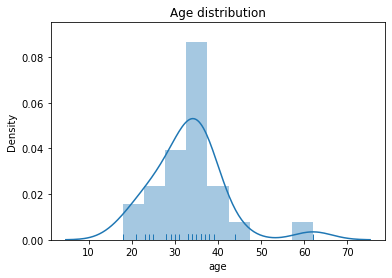

In [23]:
# AGE
ax = sns.distplot(survey['age'], rug=True)
plt.title('Age distribution')
survey['age'].describe()

In [24]:
print('Number participants in their 30s:', survey[(survey['age']>=30) & (survey['age']<40)].shape[0])

Number participants in their 30s: 16


female = 10 
male = 16


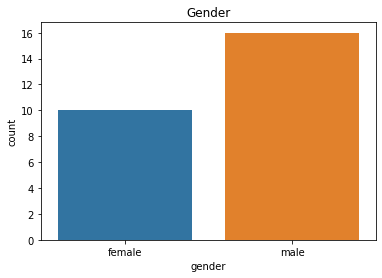

In [25]:
# GENDER
ax = sns.countplot(x="gender", data=survey)
plt.title('Gender')
print('female =', sum(survey['gender']=='female'), '\nmale =', sum(survey['gender']=='male'))

In [26]:
# EXPERIENCE
print('Count\n', survey.groupby('experience').size())
print('\nPercentage\n', 100*survey.groupby('experience').size()/survey.shape[0])


Count
 experience
1     1
2     3
3    13
4     9
dtype: int64

Percentage
 experience
1     3.846154
2    11.538462
3    50.000000
4    34.615385
dtype: float64


median: 3.0


/Users/matthiastreder/miniconda3/envs/MRI-GAN/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matthiastreder/miniconda3/envs/MRI-GAN/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


count    26.000000
mean      6.115385
std       5.339115
min       1.000000
25%       2.000000
50%       3.000000
75%      10.500000
max      17.000000
Name: years, dtype: float64

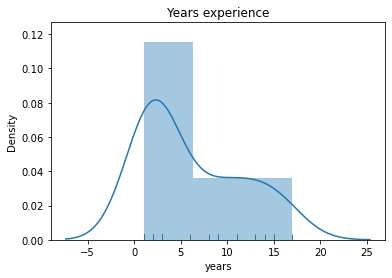

In [27]:
# YEARS
sns.distplot(survey['years'], rug=True) #, bins=range(10), kde_kws={'clip': (0.0, 20.0)})
plt.title('Years experience')
print('median:', survey['years'].median())
survey['years'].describe()


In [28]:
# HOW MANY MRIs
survey.groupby('number').size()

# ax = sns.countplot(x="number", data=survey)
# plt.title('How many MRIs')
# plt.grid()

number
1     3
2    20
3     2
4     1
dtype: int64

------

<a id="experiment"></a>
# Combine experiment data
[back to top](#top)

Collects data from all participants and combines into a single dataframe.

In [29]:
print('Processing', len(files), 'data files')

col_names = ['blockorder', 'blockname', 'blocknumber', 'task', 'trialcount', 'tablerow', 'key', 'status', 
             'RT', 'target_button', 'batch', 'timeout', 'ITI',
             'rate', 'rate_RT', 'rate_status']

Processing 26 data files


In [30]:
# concatenate data from all participants

# df = pd.read_csv(files[0], header=None, names = col_names, delimiter=' ')

dfs = []
for ix, file in enumerate(files):
    df = pd.read_csv(file, header=None, names = col_names, delimiter=' ')
    df['participant'] = ix+1
    df['correct'] = 2 - df['status']  # correct will code for correct(=1), incorrect(=0) response
    df['real'] = 2 - df['key']        # real will code for real(=1), fake(=0) image
    df['rate'] = 6 - df['rate']       # subjective rating from 1 (very fake) to 5 (very real)
    df['experience'] = survey[survey.participant_nr == ix + 1]['experience'][0] # save experience number for group analysis
    
    dfs.append(df)
#     print(f'Participant {ix+1} RT: {df.RT.median():2.2f}')

df = pd.concat(dfs, axis=0)

In [31]:
# reorder/rename batch 
b = df.batch.astype('category')
b = b.cat.reorder_categories([1,2,3,4,5,0]).cat.rename_categories({0:'real', 1:344, 2:1055, 3:7954, 4:24440, 5:60000})
df.batch = b

In [32]:
# save data
with open(results_dir + f'psytoolkit_all_participants{len(files)}.pickle', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# also export as csv
df.to_csv(results_dir + f'psytoolkit_all_participants{len(files)}.csv')

<a id="detection_task"></a>
# Detection task
[back to top](#top)

In [33]:
# Load data (deserialize)
with open(results_dir + f'psytoolkit_all_participants26.pickle', 'rb') as f:
    detection_task = pickle.load(f)

In [34]:
# detection_task = pd.read_csv(results_dir + f'all_participants{len(files)}.csv') # , header=None, names = col_names, delimiter=' ')
detection_task = detection_task[detection_task['blockname'] == 'MAIN_EXPERIMENT_BLOCK']
detection_task.head(3)

,blockorder,blockname,blocknumber,task,trialcount,tablerow,key,status,RT,target_button,batch,timeout,ITI,rate,rate_RT,rate_status,participant,correct,real,experience
30,1,MAIN_EXPERIMENT_BLOCK,3,MAIN_EXPERIMENT_TASK,31,91,2,1,4101,2,7954,0,478,6,0,0,1,1,0,3
31,1,MAIN_EXPERIMENT_BLOCK,3,MAIN_EXPERIMENT_TASK,32,138,1,2,5098,2,60000,0,432,6,0,0,1,0,1,3
32,1,MAIN_EXPERIMENT_BLOCK,3,MAIN_EXPERIMENT_TASK,33,77,1,2,2288,2,7954,0,529,6,0,0,1,0,1,3


In [35]:
# clean RTs
detection_task = clean_RT_data(detection_task, 'RT', low_RT=150, high_RT=20000, n_timeouts=30)
detection_task.shape

1 participants have >30 timeouts, removing them
Removing 16 trials with RT >= 20000


(5984, 20)

In [36]:
# calculate trimmed average
RT_av = detection_task.groupby(['participant','batch'])[['RT', 'experience']].\
aggregate(lambda x: trim_mean_upper(x, 0.05)).reset_index()
RT_av.head(3)

,participant,batch,RT,experience
0,1,344,1251.366667,3.0
1,1,1055,1168.310345,3.0
2,1,7954,1583.133333,3.0


In [37]:
# calculate average response
button_av = detection_task.groupby(['participant','batch'])[['real', 'correct', 'experience']].mean().reset_index()
button_av['real'] *= 100
button_av['correct'] *= 100
button_av.head(3)

,participant,batch,real,correct,experience
0,1,344,43.750000,56.250000,3.0
1,1,1055,25.806452,74.193548,3.0
2,1,7954,25.000000,75.000000,3.0


Batch 60000 vs Real: RanksumsResult(statistic=-4.76339967571358, pvalue=1.903582729938158e-06)


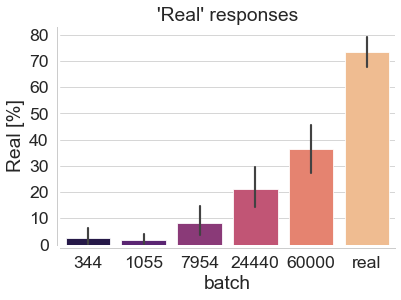

In [38]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='real', palette="magma", data=button_av)
    plt.ylabel('Real [%]')
    plt.title('\'Real\' responses')
    sns.despine(ax=ax, offset=3)
    plt.savefig('behavioural_real.png', dpi=200, bbox_inches='tight')
    
print('Batch 60000 vs Real:', stats.ranksums(button_av[button_av.batch==60000]['real'],button_av[button_av.batch=='real']['real']))

Batch 60000 vs Real: RanksumsResult(statistic=-1.4261094752136378, pvalue=0.1538367441537023)


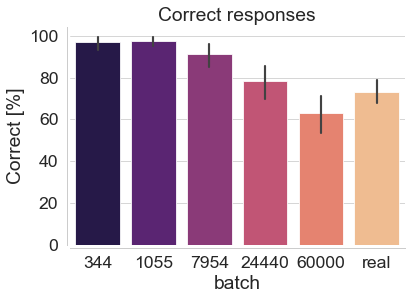

In [39]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='correct', palette="magma", data=button_av)
    plt.ylabel('Correct [%]')
    plt.title('Correct responses')
    sns.despine(ax=ax, offset=3)
    plt.savefig('behavioural_correct.png', dpi=200, bbox_inches='tight')
    
print('Batch 60000 vs Real:', stats.ranksums(button_av[button_av.batch==60000]['correct'],button_av[button_av.batch=='real']['correct']))

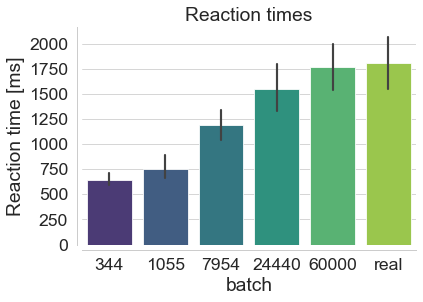

In [40]:
# palettes: crest magma rocket rocket_r viridis
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    
    ax = sns.barplot(x='batch', y='RT', palette="viridis", data=RT_av)
    plt.title('Reaction times')
    plt.ylabel('Reaction time [ms]')
    sns.despine(ax=ax, offset=5)
    plt.savefig('behavioural_RT.png', dpi=200, bbox_inches='tight')

<a id="detection_task_stats"></a>
## Statistical analysis
[back to top](#top)

In [47]:
# restrict to data without 'real' batch
stat_button = button_av[button_av['batch']!='real']
stat_RT = RT_av[RT_av['batch']!='real']

In [48]:
stat_button.loc[:,'log_batch'] = np.log(stat_button.batch.astype('object').astype('float'))
stat_RT.loc[:, 'log_batch'] = np.log(stat_RT.batch.astype('object').astype('float'))

/Users/matthiastreder/miniconda3/envs/MRI-GAN/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
# [DO NOT USE, USE linear mixed model instead]
# linear regression 
fit_button = sm.OLS.from_formula('real ~ log_batch', data=stat_button).fit()
fit_RT = sm.OLS.from_formula('RT ~ log_batch', data=stat_RT).fit()

print(fit_button.summary())
print(fit_RT.summary())

In [49]:
# linear mixed model
md = smf.mixedlm("RT ~ log_batch", stat_RT, groups=stat_RT["participant"]).fit()
print('REACTION TIME:')
print(md.summary())

md = smf.mixedlm("real ~ log_batch", stat_button, groups=stat_button["participant"]).fit()
print('REAL response:')
print(md.summary())

md = smf.mixedlm("correct ~ log_batch", stat_button, groups=stat_button["participant"]).fit()
print('CORRECT response:')
print(md.summary())

REACTION TIME:
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  RT        
No. Observations:    125      Method:              REML      
No. Groups:          25       Scale:               92982.8273
Min. group size:     5        Log-Likelihood:      -906.2463 
Max. group size:     5        Converged:           Yes       
Mean group size:     5.0                                     
-------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------
Intercept   -747.339  140.467 -5.320 0.000 -1022.649 -472.029
log_batch    224.705   14.189 15.837 0.000   196.896  252.515
Group Var 104343.269  129.724                                

REAL response:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: real     
No. Observations: 125     Method:             REML     
No. Groups:     

In [50]:
# Wilcoxon signed-rank tests for batch 60000 vs real
print('RT:', stats.wilcoxon(RT_av[RT_av.batch==60000].RT, RT_av[RT_av.batch=='real'].RT))
print('Real:', stats.wilcoxon(button_av[button_av.batch==60000].real, button_av[button_av.batch=='real'].real))
print('Correct:', stats.wilcoxon(button_av[button_av.batch==60000].correct, button_av[button_av.batch=='real'].correct))

RT: WilcoxonResult(statistic=146.0, pvalue=0.6720751523971558)
Real: WilcoxonResult(statistic=0.0, pvalue=5.960464477539063e-08)
Correct: WilcoxonResult(statistic=119.0, pvalue=0.25210392475128174)


<a id="detection_task_subgroup"></a>
## Detection task subgroup analysis
[back to top](#top)

Analyze the experience = 3 and 4 groups separately. Is there a group difference in RT, correct or real score?



In [ ]:
# Wilcoxon tests for group difference between the two experience groups (3 and 4)
# The test is repeated for every batch separately
RT_av2 = RT_av[RT_av.experience>=3]
wilcoxon_ranksum(RT_av2['RT'], RT_av2['experience'], RT_av2['batch'])

button_av2 = button_av[button_av.experience>=3]
wilcoxon_ranksum(button_av2['correct'], button_av2['experience'], button_av2['batch'])

button_av2 = button_av[button_av.experience>=3]
wilcoxon_ranksum(button_av2['real'], button_av2['experience'], button_av2['batch'])

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='real', hue='experience', palette="magma", data=button_av[button_av.experience>=3])
    plt.ylabel('Real [%]')
    plt.title('\'Real\' responses')
    sns.despine(ax=ax, offset=3)

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='correct', hue='experience', palette="magma", data=button_av[button_av.experience>=3])
    plt.ylabel('Correct [%]')
    plt.title('Correct responses')
    sns.despine(ax=ax, offset=3)

In [ ]:
# palettes: crest magma rocket rocket_r viridis
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    
    ax = sns.barplot(x='batch', y='RT', hue='experience', palette="viridis", data=RT_av[RT_av.experience>=3])
    plt.title('Reaction times')
    plt.ylabel('Reaction time [ms]')
    sns.despine(ax=ax, offset=5)

-----

<a id="rating_task"></a>
# Rating task
[back to top](#top)

In [51]:
# Load data (deserialize)
with open(results_dir + f'psytoolkit_all_participants{len(files)}.pickle', 'rb') as f:
    rating_task = pickle.load(f)
    
rate_labels = ('very\nfake', 'relatively\nfake', 'neutral', 'relatively\nreal', 'very\nreal')

In [52]:
rating_task = rating_task[rating_task['blockname'] == 'RATING_BLOCK']
rating_task.head(3)

,blockorder,blockname,blocknumber,task,trialcount,tablerow,key,status,RT,target_button,batch,timeout,ITI,rate,rate_RT,rate_status,participant,correct,real,experience
270,1,RATING_BLOCK,4,RATING_TASK,271,1,0,0,0,0,344,0,0,4,8075,1,1,2,2,3
271,1,RATING_BLOCK,4,RATING_TASK,272,6,0,0,0,0,1055,0,0,2,4962,1,1,2,2,3
272,1,RATING_BLOCK,4,RATING_TASK,273,16,0,0,0,0,24440,0,0,2,7500,1,1,2,2,3


In [53]:
# clean RTs
rating_task = clean_RT_data(rating_task, 'rate_RT', low_RT=150, high_RT=10000)
rating_task.shape

Removing 6 trials with RT <= 150


(774, 20)

In [54]:
# calculate trimmed average
rate_RT_av = rating_task.groupby(['participant','batch'])[['rate_RT', 'experience']].\
aggregate(lambda x: trim_mean_upper(x, 0.05)).reset_index()
rate_RT_av.head(3)

,participant,batch,rate_RT,experience
0,1,344,1620.25,3.0
1,1,1055,1742.50,3.0
2,1,7954,2212.50,3.0


In [55]:
# calculate average rate
rate_av = rating_task.groupby(['participant','batch'])[['rate', 'experience']].mean().reset_index()
rate_av.head(3)

,participant,batch,rate,experience
0,1,344,3.2,3.0
1,1,1055,2.4,3.0
2,1,7954,2.6,3.0


Batch 60000 vs Real: RanksumsResult(statistic=-4.255026777218504, pvalue=2.0902399884646444e-05)


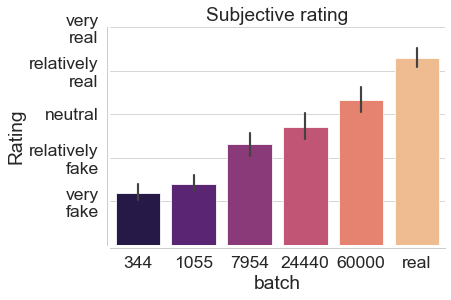

In [56]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='rate', palette="magma", data=rate_av)
    plt.yticks([1,2,3,4,5])
    ax.set_yticklabels(rate_labels)
    plt.ylabel('Rating')
    plt.title('Subjective rating')
    sns.despine(ax=ax, offset=3)
    plt.savefig('behavioural_subjective_rate.png', dpi=200, bbox_inches='tight')
    
print('Batch 60000 vs Real:', stats.ranksums(rate_av[rate_av.batch==60000]['rate'],rate_av[rate_av.batch=='real']['rate']))

Batch 60000 vs Real: RanksumsResult(statistic=1.5372999969305563, pvalue=0.12421986224152338)


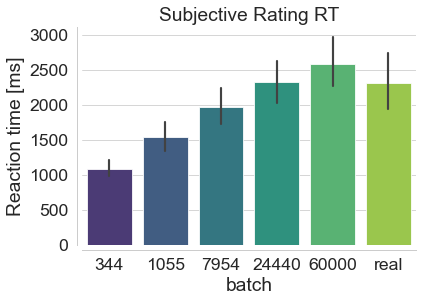

In [57]:
# palettes: crest magma rocket rocket_r viridis
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    
    ax = sns.barplot(x='batch', y='rate_RT', palette="viridis", data=rate_RT_av)
    plt.title('Subjective Rating RT')
    plt.ylabel('Reaction time [ms]')
    sns.despine(ax=ax, offset=5)
    plt.savefig('behavioural_subjective_rate_RT.png', dpi=200, bbox_inches='tight')
    
print('Batch 60000 vs Real:', stats.ranksums(rate_RT_av[rate_RT_av.batch==60000]['rate_RT'],rate_RT_av[rate_RT_av.batch=='real']['rate_RT']))

<a id="rating_task_stats"></a>
## Statistical analysis
[back to top](#top)

In [59]:
stat_rate_button = rate_av[rate_av['batch']!='real']
stat_rate_RT = rate_RT_av[rate_RT_av['batch']!='real']

# add log batch
stat_rate_button['log_batch'] = np.log(stat_rate_button.batch.astype('object').astype('float'))
stat_rate_RT['log_batch'] = np.log(stat_rate_RT.batch.astype('object').astype('float'))

/var/folders/60/5mt6_9q52xgcr_b3bq5y3cfr0000gn/T/ipykernel_6534/3464326308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_rate_button['log_batch'] = np.log(stat_rate_button.batch.astype('object').astype('float'))
/var/folders/60/5mt6_9q52xgcr_b3bq5y3cfr0000gn/T/ipykernel_6534/3464326308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_rate_RT['log_batch'] = np.log(stat_rate_RT.batch.astype('object').astype('float'))


In [60]:
# linear mixed model
md = smf.mixedlm("rate_RT ~ log_batch", stat_rate_RT, groups=stat_rate_RT["participant"]).fit()
print('REACTION TIME (ratings):')
print(md.summary())

REACTION TIME (ratings):
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: rate_RT    
No. Observations:   130     Method:             REML       
No. Groups:         26      Scale:              290663.3862
Min. group size:    5       Log-Likelihood:     -1009.0306 
Max. group size:    5       Converged:          Yes        
Mean group size:    5.0                                    
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept   -499.587  230.387 -2.168 0.030 -951.137 -48.037
log_batch    279.875   24.599 11.377 0.000  231.661 328.088
Group Var 164243.523  130.054                              



In [62]:
# statsmodel does not feature a multi-level ordinal regression model 
# with random effect at the time of this analysis, therefore the data is exported
# and the analysis is performed in R (refer to the ordinal_regression_rating_task.R script)
rating_task.to_csv(results_dir + 'rating_task.csv')